# PCA vs HOPCA

I will write the comments in italian because I truly believe that very few people other than me will read it. If this is an issue tell me and I will translate everything

## Scopo

Lo scopo e' quello di confrontare PCA con la sua versione tensoriale. Questo notebook parte come un proof of concept, quindi per ora lo faccio per 1 solo numero di reynolds (8000) con forte subsampling e vedo se ci sono differenze

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
from utils import print_statistics, load_dataset


In [2]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)

Nx, Ny = metadata['global']['Nxyz']

# Load grid
X_filename = metadata['global']['grid']['x']
Y_filename = metadata['global']['grid']['y']
X = np.fromfile(data_paths[0] + '/' + X_filename, dtype='<f4').reshape(Ny, Nx)
Y = np.fromfile(data_paths[0] + '/' + Y_filename, dtype='<f4').reshape(Ny, Nx)

# Subsample grid
X_sub = X[::subsample_x, ::subsample_y]
Y_sub = Y[::subsample_x, ::subsample_y]
Ny_sub, Nx_sub = X_sub.shape

print(f"Original grid: ({Nx}, {Ny})")
print(f"Subsampled grid: ({Nx_sub}, {Ny_sub})")

Original grid: (1600, 2000)
Subsampled grid: (160, 200)


In [3]:
component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']

# Molar masses (g/mol)
molar_masses = {
    'YH': 1.0,
    'YH2': 2.0,
    'YO': 8.0,
    'YO2': 16.0,
    'YOH': 9.0,
    'YH2O': 10.0,
    'YHO2': 17.0,
    'YH2O2': 18.0
}


file_key_map = {
    'YH': 'YH filename',
    'YH2': 'YH2 filename',
    'YO': 'YO filename',
    'YO2': 'YO2 filename',
    'YOH': 'YOH filename',
    'YH2O': 'YH2O filename',
    'YHO2': 'YHO2 filename',
    'YH2O2': 'YH2O2 filename'
}

In [4]:

tensors = {path: load_dataset(path, component_names, file_key_map, Ny=Ny, Nx=Nx, n_snapshots=n_snapshots, molar_masses=molar_masses, subsample_x=10, subsample_y=10)
           for path in data_paths}


  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [5]:
for dataset_path, tensor in tensors.items():
    if "nonreact" not in dataset_path:
        print("\n" + "=" * 80)
        print(f"Dataset: {dataset_path}")
        print("=" * 80)
        print(f"{'Component':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
        print("-" * 80)        
        for c_idx, comp_name in enumerate(component_names):
            component_data = tensor[:, :, c_idx, :]
            mean_val = np.mean(component_data)
            std_val = np.std(component_data)
            min_val = np.min(component_data)
            max_val = np.max(component_data)
            
            print(f"{comp_name:<15} {mean_val:<12.6e} {std_val:<12.6e} {min_val:<12.6e} {max_val:<12.6e}")
        
        print("-" * 80)
        
        # Overall tensor stats
        print(f"Overall Tensor Statistics:")
        print(f"  Shape: {tensor.shape}")
        print(f"  Total elements: {tensor.size:,}")
        print(f"  Memory size: {tensor.nbytes / (1024**2):.2f} MB")
        print(f"  Global mean: {np.mean(tensor):.6e}")
        print(f"  Global std:  {np.std(tensor):.6e}")
        print(f"  Global min:  {np.min(tensor):.6e}")
        print(f"  Global max:  {np.max(tensor):.6e}")
        print("=" * 80)



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              2.108595e-04 4.958064e-04 -4.988369e-25 4.876255e-03
YH2             3.141716e-02 8.368027e-02 0.000000e+00 3.249700e-01
YO              8.207165e-05 2.683234e-04 -1.025646e-14 1.899564e-03
YO2             1.125224e-02 5.756119e-03 1.262478e-07 1.456250e-02
YOH             1.605751e-04 5.228729e-04 -1.954558e-11 3.019940e-03
YH2O            3.061480e-03 6.672779e-03 -2.330029e-07 2.365345e-02
YHO2            2.972886e-07 8.293629e-07 -2.481960e-17 1.084706e-05
YH2O2           1.741783e-08 4.961067e-08 -8.167948e-13 7.718936e-07
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mean: 5.773

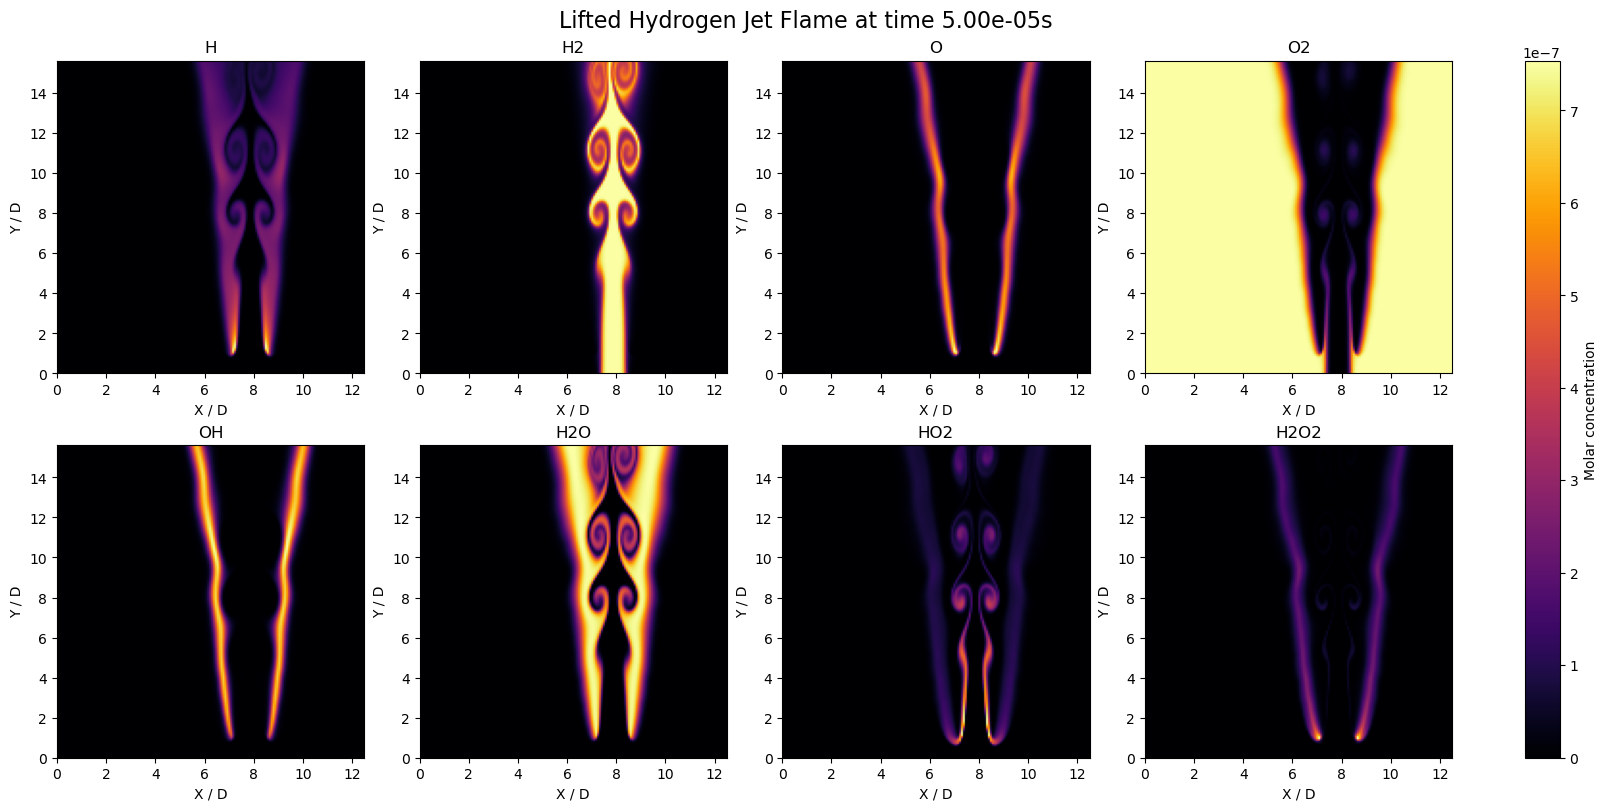

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < tensor.shape[2]:
        im = ax.imshow(
            tensor[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/original_data_t10.png')
plt.show()


## Preprocessing

Visto che sto lavorando solo con specie chimiche riscalo con logaritmo, dividere per la varianza mi sembra un po' sospetto. Per centrare i dati prendo la media dei valori non nulli.

In [7]:
component_means_all = {}
epsilon = 1e-12  
tensors_scaled = {}  # Create new dictionary for scaled tensors

for dataset_path, tensor in tensors.items():
    
    print("\n" + "=" * 50)
    print(f"Dataset: {dataset_path}")
    print("Applying log scaling and centering to chemical species...")
    print("=" * 50)
    print(f"{'Component':<15} {'Mean (after log)':<20} {'Std':<15} {'Max (log)':<15}")
    print("-" * 70)
    
    n_components = tensor.shape[2]
    
    # Create a copy of the original tensor
    tensor_scaled = tensor.copy()
    
    for c_idx, comp_name in enumerate(component_names):        
        component_data = tensor_scaled[:, :, c_idx, :]
        component_data = np.log10(np.maximum(component_data, epsilon))
 
        tensor_scaled[:, :, c_idx, :] = component_data
    
        # Store the scaled tensor in the new dictionary
        tensors_scaled[dataset_path] = tensor_scaled
        component_means_all[comp_name] = {
            "mean_after_log": mean_val,
            "std_after_log": std_val
        }

        print(f"{comp_name:<15} {mean_val:<20.3e} {std_val:<15.3e} {component_data.max():<15.3e}")

print("\nLog scaling and centering complete.\n")



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Applying log scaling and centering to chemical species...
Component       Mean (after log)     Std             Max (log)      
----------------------------------------------------------------------
YH              1.742e-08            4.961e-08       -2.312e+00     
YH2             1.742e-08            4.961e-08       -4.882e-01     
YO              1.742e-08            4.961e-08       -2.721e+00     
YO2             1.742e-08            4.961e-08       -1.837e+00     
YOH             1.742e-08            4.961e-08       -2.520e+00     
YH2O            1.742e-08            4.961e-08       -1.626e+00     
YHO2            1.742e-08            4.961e-08       -4.965e+00     
YH2O2           1.742e-08            4.961e-08       -6.112e+00     

Log scaling and centering complete.



In [8]:
print_statistics(tensors_scaled, component_names)



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              -9.212932e+00 3.771220e+00 -1.200000e+01 -2.311914e+00
YH2             -7.728262e+00 4.357472e+00 -1.200000e+01 -4.881567e-01
YO              -9.351383e+00 3.347451e+00 -1.200000e+01 -2.721346e+00
YO2             -2.309645e+00 9.944892e-01 -6.898776e+00 -1.836764e+00
YOH             -9.191934e+00 3.512371e+00 -1.200000e+01 -2.520002e+00
YH2O            -8.616590e+00 4.312756e+00 -1.200000e+01 -1.626106e+00
YHO2            -9.961307e+00 2.581884e+00 -1.200000e+01 -4.964688e+00
YH2O2           -1.060957e+01 1.974835e+00 -1.200000e+01 -6.112443e+00
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  

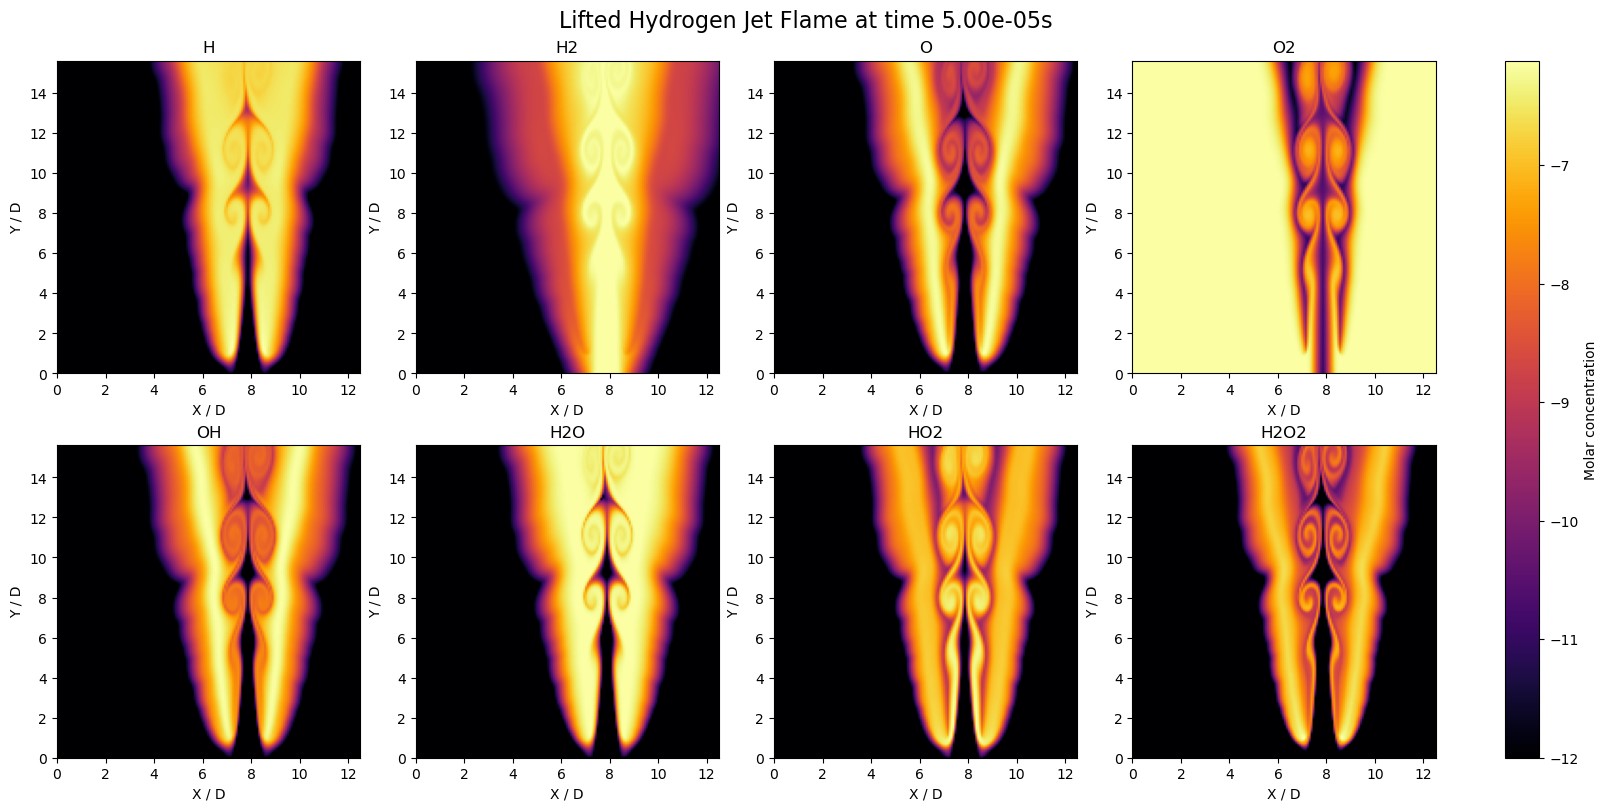

In [9]:
Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()
tensor_plot =  tensors_scaled[list(tensors_scaled.keys())[0]]
for idx, ax in enumerate(axes):
    if idx < tensor_plot.shape[2]:
        im = ax.imshow(
            tensor_plot[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/processed_data_t10.png')
plt.show()


## PCA classica

Per prima cosa bisogna implementare la PCA nella sua forma piu' tradizionale

In [10]:
for dataset_path, tensor in tensors_scaled.items():
    X = tensor.reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U, sigma, V = np.linalg.svd(X, full_matrices=False)
    
    loadings = V.T  # Now shape is (n_components x n_modes)
    
    summary_data = []
    
    for mode in range(8):
        mode_vector = np.abs(loadings[:, mode])
        total = np.sum(mode_vector)
        rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
        
        # Get top 3 species
        top3_indices = np.argsort(rel_contrib)[:][::-1]
        
        top_species = []
        for idx in top3_indices:
            top_species.append(f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)")
        
        summary_data.append({
            'Mode': mode + 1,
            '1st Species': top_species[0],
            '2nd Species': top_species[1],
            '3rd Species': top_species[2],
            '4rd Species': top_species[3],
            '5rd Species': top_species[4],
            '6rd Species': top_species[5],
            '7rd Species': top_species[6],
            '8rd Species': top_species[7],
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print(f"CONTRIBUTING SPECIES FOR EACH PCA MODE - {dataset_path}")
    print("="*80)
    print(df_summary.to_string(index=False))
    print("="*80)


CONTRIBUTING SPECIES FOR EACH PCA MODE - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species  3rd Species   4rd Species  5rd Species   6rd Species  7rd Species 8rd Species
    1 YH2O2 (12.5%) YHO2 (12.5%) YH2O (12.5%)   YOH (12.5%)  YO2 (12.5%)    YO (12.5%)  YH2 (12.5%)  YH (12.5%)
    2  YH2O (17.7%)   YO (17.6%)  YH2 (17.2%)  YHO2 (17.2%) YH2O2 (7.7%)     YH (7.7%)   YO2 (7.4%)  YOH (7.4%)
    3   YOH (18.5%)  YO2 (18.4%)   YH (16.2%) YH2O2 (16.2%)  YHO2 (8.8%)    YH2 (8.8%)  YH2O (6.6%)   YO (6.6%)
    4 YH2O2 (22.5%)   YH (22.4%) YH2O (12.3%)    YO (12.2%)   YO2 (9.0%)    YOH (8.9%)   YH2 (6.4%) YHO2 (6.4%)
    5    YO (14.5%) YH2O (14.3%)   YH (13.3%) YH2O2 (13.2%)  YO2 (11.8%)   YOH (11.7%) YHO2 (10.6%) YH2 (10.5%)
    6   YH2 (17.2%) YHO2 (16.7%)  YOH (15.7%)   YO2 (15.5%)   YH (13.4%) YH2O2 (13.2%)    YO (4.4%) YH2O (3.9%)
    7  YHO2 (18.4%)  YH2 (18.3%)   YO (16.4%)  YH2O (15.9%) YH2O2 (9.0%)     YH (8.8%)   YO2 

(6400000, 8)
Total spatial features: 6400000

Top modes energy content:


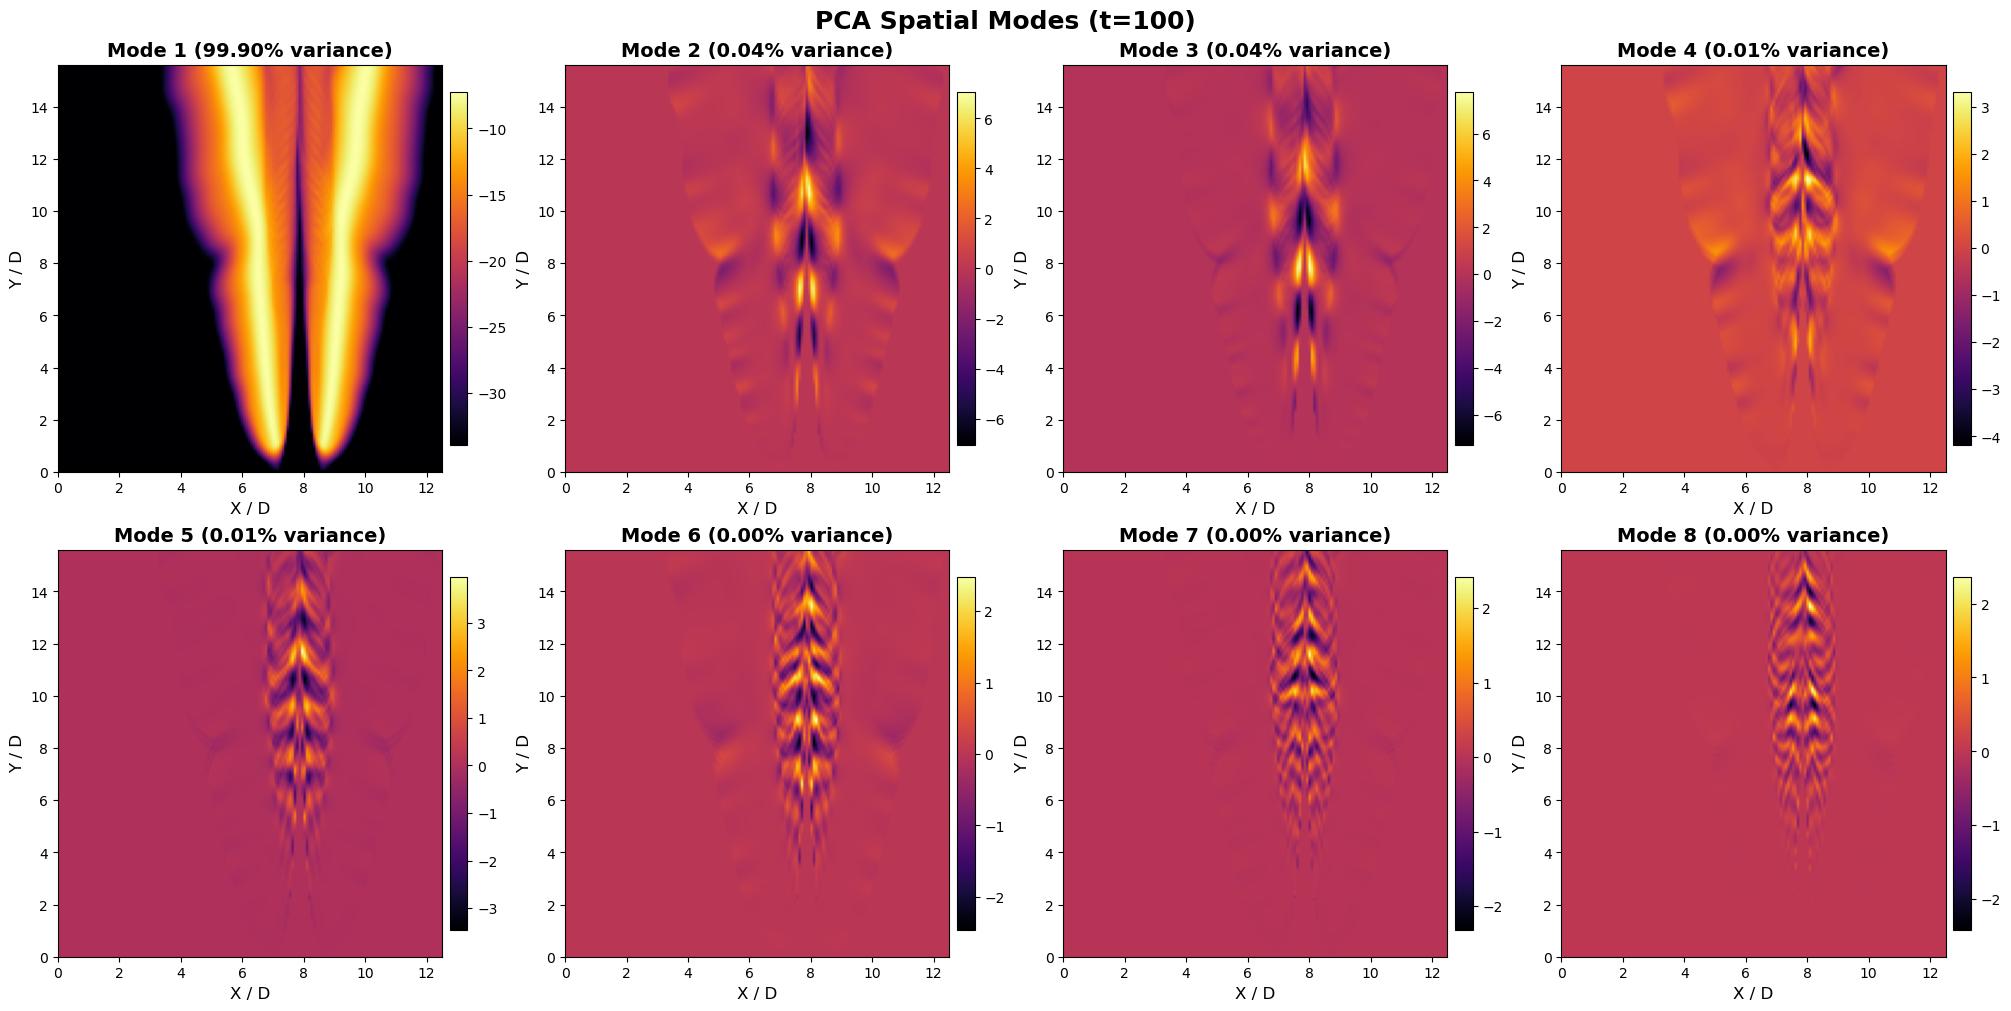

In [11]:
Phi = U
print(U.shape)
T = np.diag(sigma) @ V
energy = sigma**2
energy_fraction = energy / np.sum(energy)
print(f"Total spatial features: {X.shape[0]}")
print("\nTop modes energy content:")

Lx, Ly = 12.5, 15.6  # domain size in D units
t_snapshot = 100  

fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
fig.suptitle(f"PCA Spatial Modes (t={t_snapshot})", fontsize=18, fontweight='bold')

axes = axes.flatten()

for idx in range(8):
    phi_mode = (Phi * sigma)[:, idx].reshape(Ny_sub, Nx_sub, 200)
    phi_snapshot = np.flip(phi_mode[:, :, t_snapshot], axis=0)
    
    im = axes[idx].imshow(
        phi_snapshot,
        cmap='inferno',
        extent=[0, Lx, 0, Ly],
        aspect='auto',
        vmin=phi_snapshot.min(),  # Independent min
        vmax=phi_snapshot.max()   # Independent max
    )
    
    axes[idx].set_title(
        f"Mode {idx+1} ({energy_fraction[idx]*100:.2f}% variance)",
        fontsize=14,
        fontweight='bold'
    )
    axes[idx].set_xlabel("X / D", fontsize=12)
    axes[idx].set_ylabel("Y / D", fontsize=12)
    axes[idx].tick_params(labelsize=10)
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axes[idx], orientation='vertical', pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=10)

plt.savefig('README_PLOTS/pca_spatial_modes_all.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_8827/786612801.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=12, loc='lower right')


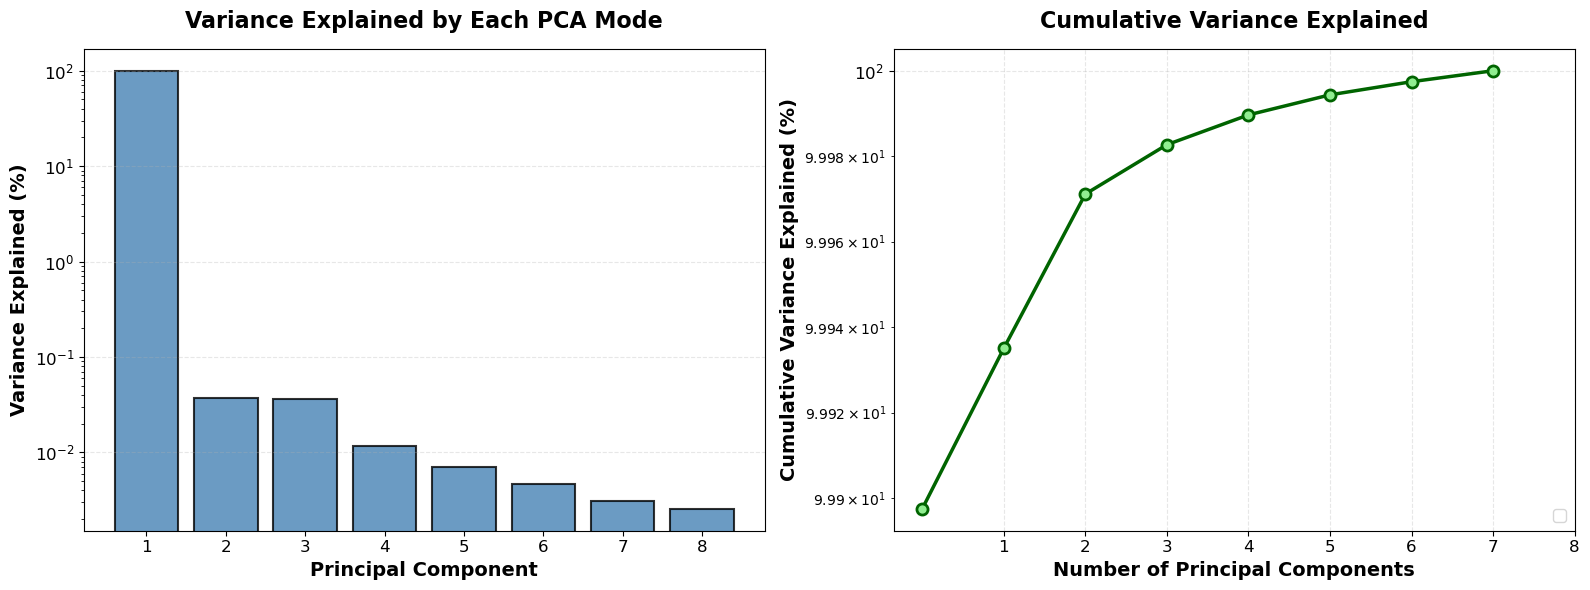


Variance Explained Summary:
  First mode: 99.90%
  First 2 modes: 99.94%
  First 3 modes: 99.97%
  First 4 modes: 99.98%


In [12]:
variance_explained = sigma**2 / np.sum(sigma**2)
cumulative_variance = np.cumsum(variance_explained)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Variance explained per mode
ax1.bar(range(1, len(variance_explained) + 1), variance_explained * 100, 
        color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Principal Component', fontsize=14, fontweight='bold')
ax1.set_ylabel('Variance Explained (%)', fontsize=14, fontweight='bold')
ax1.set_title('Variance Explained by Each PCA Mode', fontsize=16, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(labelsize=12)
ax1.set_xticks(range(1, len(variance_explained) + 1))
ax1.set_yscale("log")
# Cumulative variance explained
ax2.plot(range(0, len(cumulative_variance)), cumulative_variance * 100, 
         marker='o', markersize=8, linewidth=2.5, color='darkgreen', 
         markerfacecolor='lightgreen', markeredgewidth=2, markeredgecolor='darkgreen')
ax2.set_xlabel('Number of Principal Components', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=14, fontweight='bold')
ax2.set_title('Cumulative Variance Explained', fontsize=16, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=12, loc='lower right')
ax2.tick_params(labelsize=12)
ax2.set_xticks(range(1, len(cumulative_variance) + 1))
ax2.set_yscale("log")

plt.tight_layout()
plt.savefig('README_PLOTS/pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVariance Explained Summary:")
print(f"  First mode: {variance_explained[0]*100:.2f}%")
print(f"  First 2 modes: {cumulative_variance[1]*100:.2f}%")
print(f"  First 3 modes: {cumulative_variance[2]*100:.2f}%")
print(f"  First 4 modes: {cumulative_variance[3]*100:.2f}%")

#### RESTANO DA FARE GLI ERRORI, MA PRIMA DI SBATTERSI E' IL CASO DI CAPIRE SE VA BENE


In [15]:
decomposition_results = {}  # store factors and cores per dataset

for dataset_path, tensor in tensors_scaled.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset: {dataset_path}")
    print("=" * 100)
    
    factors = []
    for i in tqdm(range(tensor.ndim)):
        U, _, _ = np.linalg.svd(tl.unfold(tensor, mode=i), full_matrices=False)
        factors.append(U)

    core = multi_mode_dot(tensor, [U.T for U in factors], modes=range(tensor.ndim))
    print("done")
    reconst = multi_mode_dot(core, factors, modes=range(tensor.ndim))
    
    # check reconstruction accuracy
    close = np.allclose(reconst, tensor, rtol=1e-5, atol=1e-8)
    error = np.linalg.norm(np.subtract(reconst, tensor)) / np.linalg.norm(tensor)
    
    print(f"  Reconstruction close: {close}")
    print(f"  Relative reconstruction error: {error:.6e}")
    print("-" * 100)
    
    # store results
    decomposition_results[dataset_path] = {
        "core": core,
        "factors": factors,
    }

print("\n" + "=" * 100)


Performing HOSVD for dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


100%|██████████| 4/4 [00:16<00:00,  4.10s/it]


done
  Reconstruction close: True
  Relative reconstruction error: 2.001654e-15
----------------------------------------------------------------------------------------------------



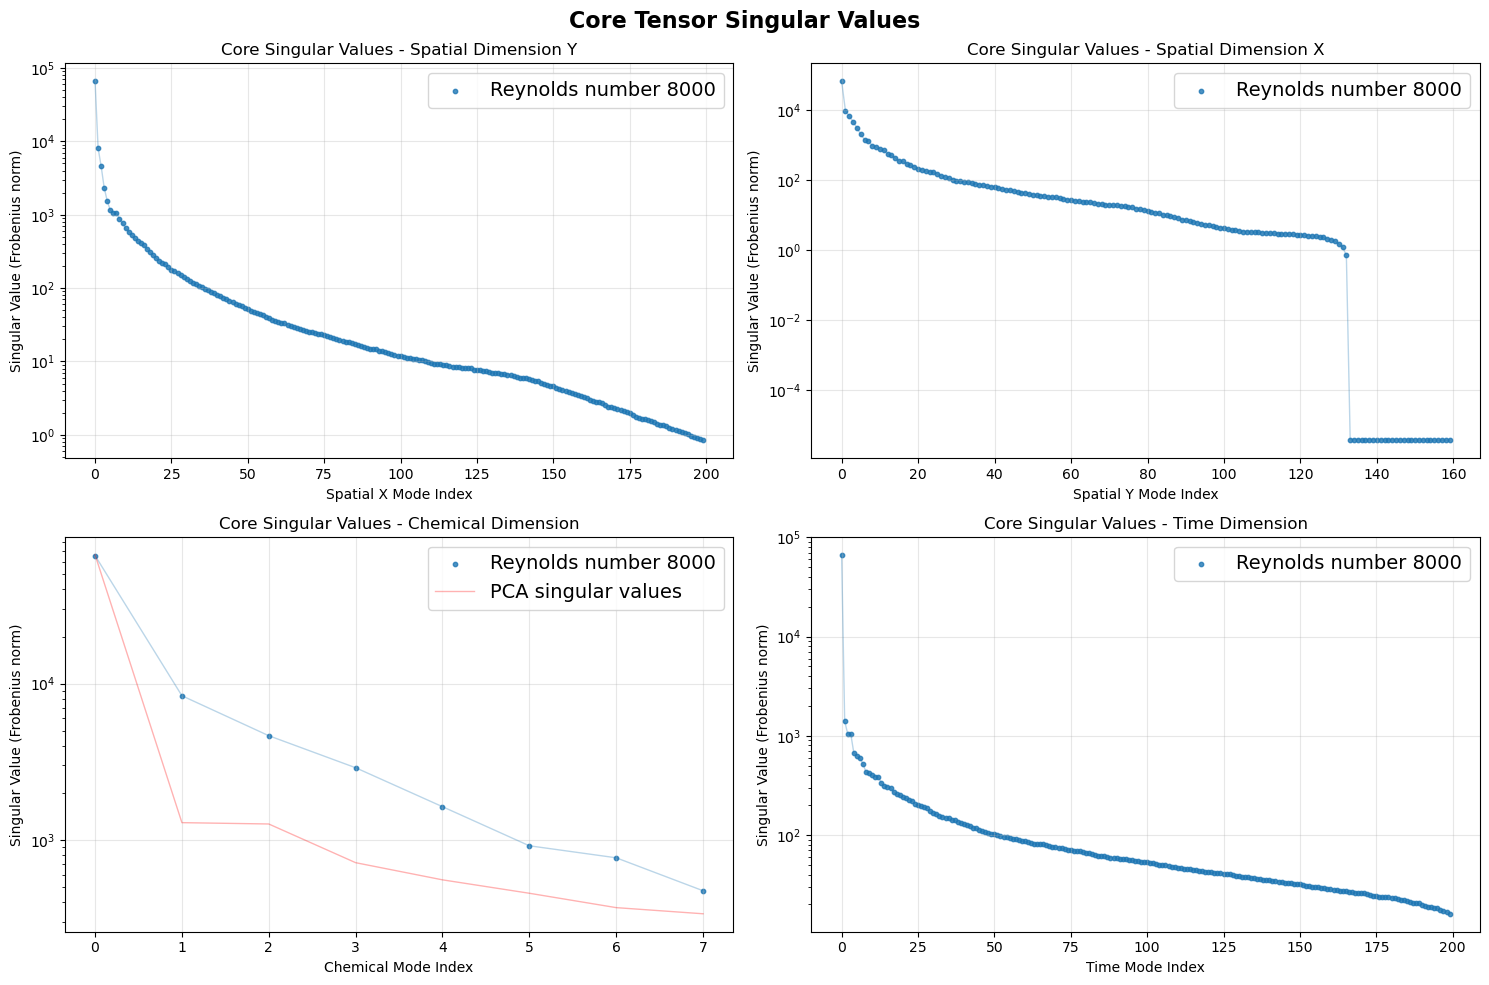

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(decomposition_results)))

for idx, (key, f) in enumerate(decomposition_results.items()):
        core = f['core']
        dataset_name = f"Reynolds number {key.split("-")[-1][:4]}"
        color = colors[idx]
        
        sv_0 = [np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])]
        ax = axes[0, 0]
        ax.scatter(range(len(sv_0)), sv_0, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_0)), sv_0, color=color, alpha=0.3, linewidth=1)
        
        sv_1 = [np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])]
        ax = axes[0, 1]
        ax.scatter(range(len(sv_1)), sv_1, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_1)), sv_1, color=color, alpha=0.3, linewidth=1)
        
        sv_chem = [np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]
        ax = axes[1, 0]
        ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=0.3, linewidth=1)
        ax.plot(range(len(sv_chem)), sigma, color='red', alpha=0.3, linewidth=1, label="PCA singular values")
        
        sv_time = [np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])]
        ax = axes[1, 1]
        ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_time)), sv_time, color=color, alpha=0.3, linewidth=1)

ax = axes[0, 0]
ax.set_xlabel('Spatial X Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension Y') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[0, 1]
ax.set_xlabel('Spatial Y Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension X') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 0]
ax.set_xlabel('Chemical Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Chemical Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 1]
ax.set_xlabel('Time Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Time Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

fig.suptitle('Core Tensor Singular Values', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('README_PLOTS/hosvd_core_vals.png', dpi=300, bbox_inches='tight')

plt.show()